# Принятие решений в бизнесе

**Цель проекта**

Выполнить приоритизацию гипотез, запустить A/B-тест и проанализировать результаты.

**Описание данных**

Данные для первой части:

Файл /datasets/hypothesis.csv

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

Данные для второй части:

Файл /datasets/orders.csv

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

**Ход исследования**
- Загружаем данные и подготовливаем их к анализу;
- Часть 1. Приоритизация гипотез;
- Часть 2. Анализ A/B-теста;
- Вывод.

### Загружаем данные и подготовливаем их к анализу

#### Загружаем данные

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_colwidth = 150

In [2]:
# Чтение файла с данными и сохранение в переменные
try:
    data, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )
except:
    data, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    )

In [3]:
# Просмотр информации о таблицах и проверка наличия дубликатов
for i in [data, orders, visitors]:
    display(i.head())
    i.info()
    print('*'*50)
    print(f'Количество дубликатов: {i.duplicated().sum()}')

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
**************************************************
Количество дубликатов: 0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
**************************************************
Количество дубликатов: 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
**************************************************
Количество дубликатов: 0


**Из общей информации датафреймов видны следующие проблемы:**
- названия столбцов следует привести к единой стилистике;
- тип данных в столбцах, которые содержат дату и время, необходимо привести к формату `datetime`.

#### Предобработка данных

In [4]:
# Приведем наименования столбцов к хорошему стилю
data.columns = [name.lower().replace(' ', '_') for name in data.columns]
# Для удобства пользования кода из теории 
orders = orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'})
# Проверим
display(data.columns)
display(orders.columns)
display(visitors.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['orderId', 'userId', 'date', 'revenue', 'group'], dtype='object')

Index(['date', 'group', 'visitors'], dtype='object')

In [5]:
# Приведем данные о времени к формату 'datetime'
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
# Проверим, что получилось
for i in [data, orders, visitors]:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1197 non-null   int64         
 1   userId   1197 non-null   int64         
 2   date     1197 non-null   datetime64[ns]
 3   revenue  1197 non-null   int64         
 4   group    1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

**Вывод:** Данные подготовлены для дальнейшего анализа. Мы исправили тип данных в столбцах, привели названия всех столбцов к единому стилю. Данные в столбцах совпадают по количеству с общим размером датафреймов - это означает, что пропуски в данных отсутствуют. Дубликаты отсутствуют.

### Приоритизация гипотез (часть 1)

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
data['ICE'] = data['impact'] * data['confidence']/data['efforts']
data['ICE'] = data['ICE'].astype('float')
data[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Применив фреймворк ICE мы получили три наиболее перспективные для изучения гипотезы:**
1) Запустить акцию, дающую скидку на товар в день рождения;

2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

#### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [8]:
data['RICE'] = (data['reach'] * data['impact'] * data['confidence'])/data['efforts']
data[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Применив фреймворк RICE мы получили три наиболее перспективные для изучения гипотезы:**
1) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;

3) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

#### Изменение приоритизации гипотез при применении RICE вместо ICE.

RICE в отличии от ICE имеет `Reach` — охват пользователей, которых затронет изменение, которое мы хотим внести;

Разница приоритезиций заключается в том, что одна учитывает кол-во пользователей, которых затронут изменения, а другая - нет.
    
Наиболее перспективными гипотезами, вошедшими в первую тройку при применении как одного, так и другого фреймворка, являются:
    
1) `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`;
    
2) `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`.

### Анализ A/B-теста

#### Проанализируем A/B-тест:

##### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

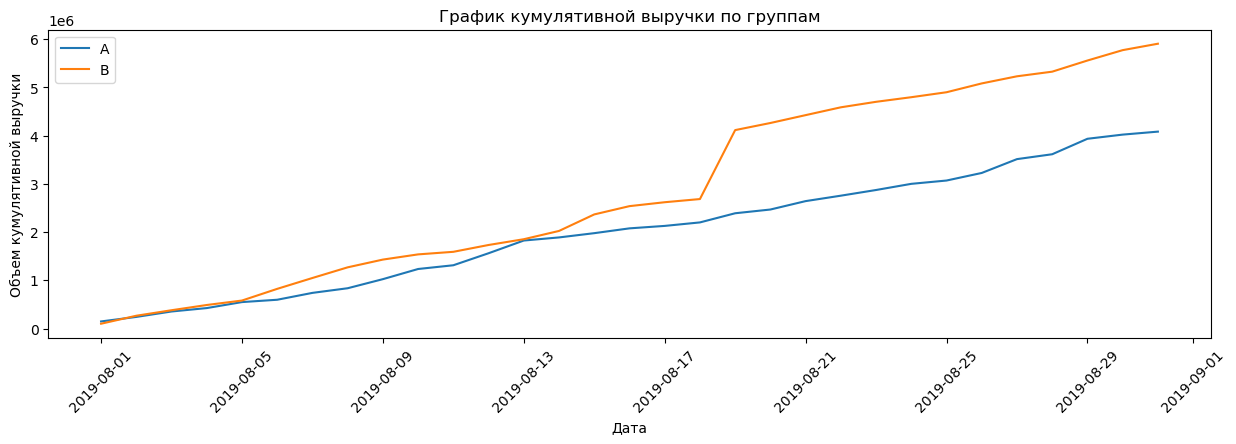

In [9]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Задаем размер графику
plt.figure(figsize=(15, 4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation=45)
plt.title("График кумулятивной выручки по группам")
plt.ylabel("Объем кумулятивной выручки")
plt.xlabel("Дата")
plt.show()

**Вывод:**
    
Группа Б стабильно показывает более высокие показатели кумулятивной выручки.

17 августа заметен резкий подъем в группе Б - возможно, увеличилась стоимость среднего чека или кол-во заказов. Мы еще не проверяли аномалии и выбросы, к их проверке приступим позже.

##### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

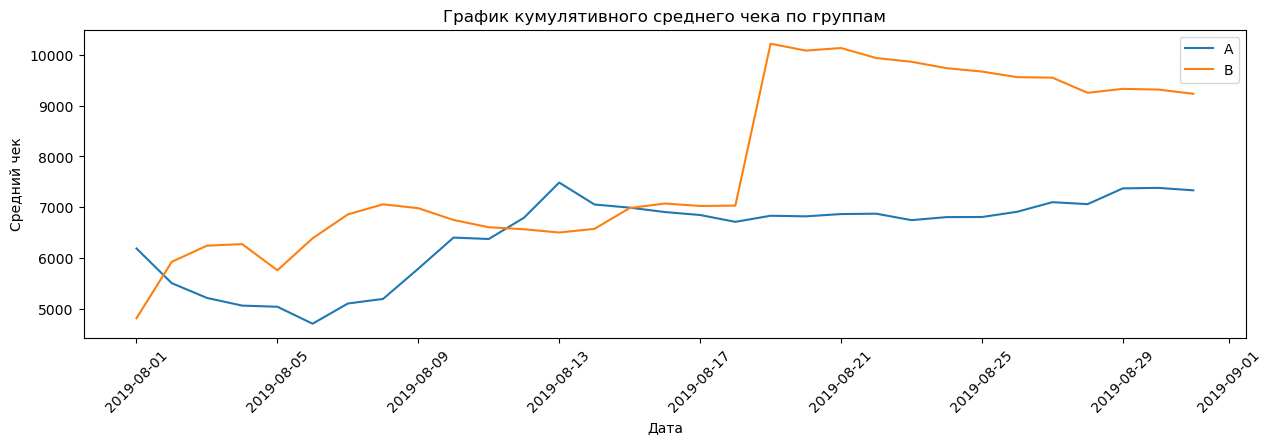

In [10]:
plt.figure(figsize=(15, 4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title("График кумулятивного среднего чека по группам")
plt.ylabel("Средний чек")
plt.xlabel("Дата")
plt.show()

**Вывод:**

Мы видим на графике, как 17 августа поменялся средний чек в группе Б, а затем наметилась тенденция к выравниванию средней - видимо, в этот период в группе Б были совершены заказы на довольно крупную сумму, которая существенно повлияла на значение среднего чека.

Кумулятивное значение среднего чека продолжает колебаться. Скорее всего, принимать решение по этой метрике рано.

##### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

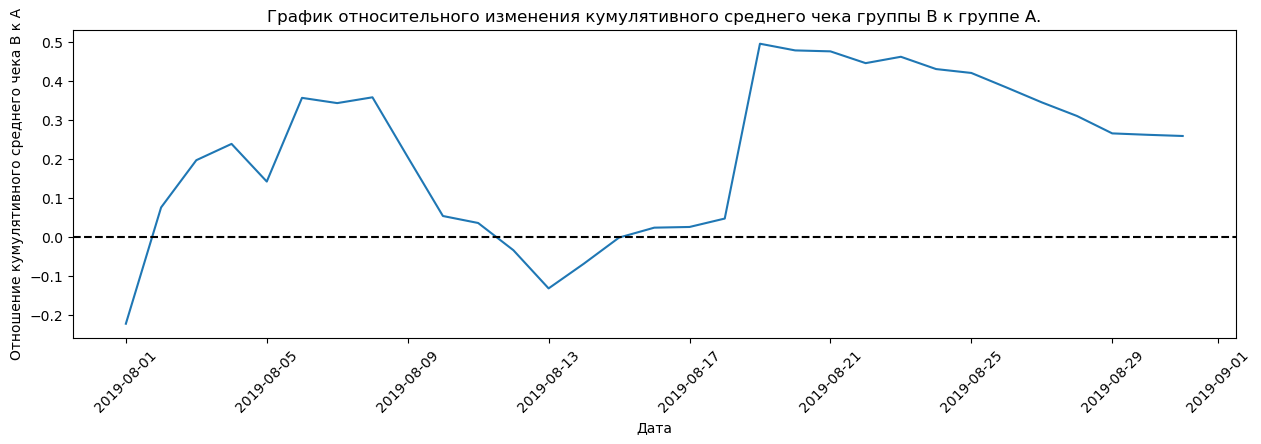

In [11]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 4))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A.")
plt.ylabel("Отношение кумулятивного среднего чека В к А")
plt.xlabel("Дата")
plt.show()

**Вывод:**
    
Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершенны аномальные заказы.

##### Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

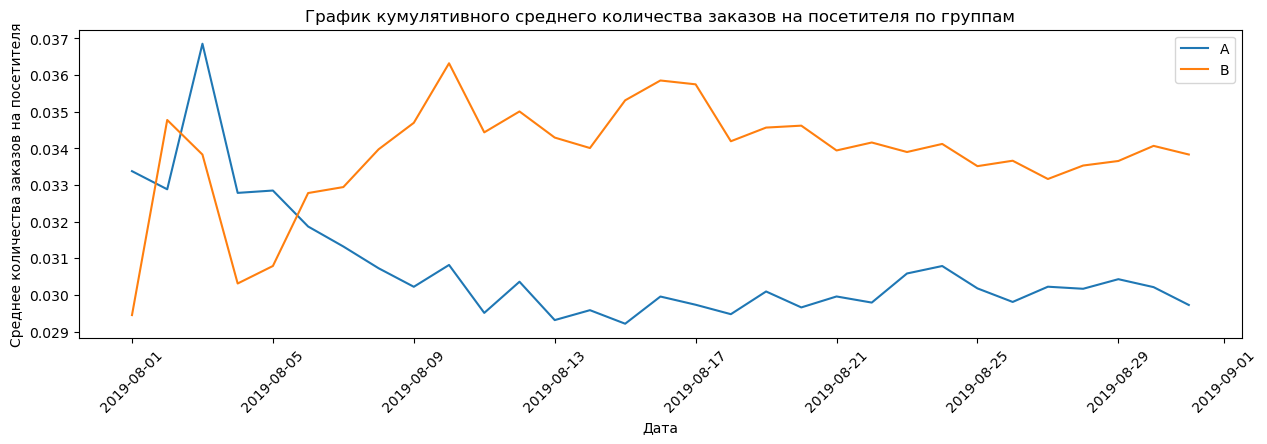

In [12]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title("График кумулятивного среднего количества заказов на посетителя по группам")
plt.ylabel("Среднее количества заказов на посетителя")
plt.xlabel("Дата")
plt.show()

**Вывод:** 
    
Кумулятивное среднее количество заказов на посетителя в группе Б превышает значение аналогичного показателя группы А

##### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

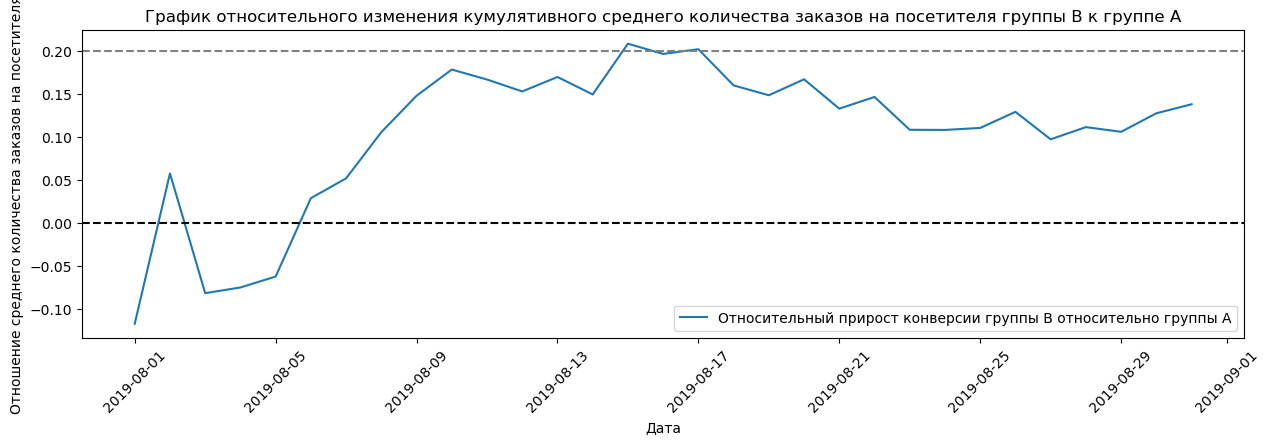

In [13]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.ylabel("Отношение среднего количества заказов на посетителя В к А")
plt.xlabel("Дата")
plt.show()

**Вывод:**

Почти с самого начала теста группа Б лидирует по конверсии: становится лучше и лучше, либо зафиксировалась около прироста в 20% относительно группы А. 

##### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [14]:
# Метод .groupby() сгруппирует заказы по пользователям
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

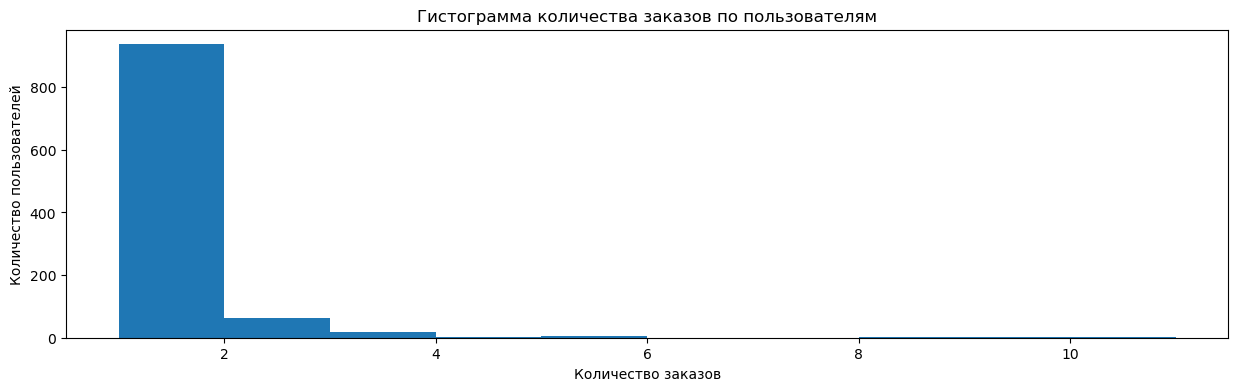

In [15]:
# Построим гистограмму распределения числа заказов по пользователям
plt.figure(figsize=(15, 4))
plt.hist(ordersByUsers['orders'])
plt.title("Гистограмма количества заказов по пользователям")
plt.ylabel("Количество пользователей")
plt.xlabel("Количество заказов")
plt.show()

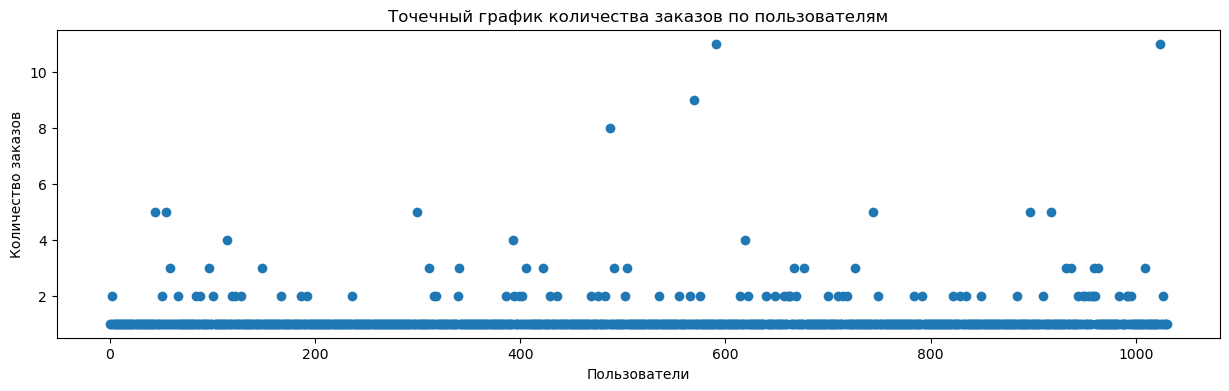

In [16]:
# Построим диаграмму методом scatter()
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(15, 4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Точечный график количества заказов по пользователям")
plt.ylabel("Количество заказов")
plt.xlabel("Пользователи")
plt.show()

**Вывод:**
    
Из графиков видно, что в среднем один пользователь делал один заказ, много пользователей с 2-3 заказами. Их точная доля не ясна, поэтому сложно понять, можно ли считать их выбросами или нет.

##### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [17]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод:**    

Не более 5% пользователей совершали больше 2-х покупок в течение тестирования. И только 1% - четыре и более.
Примем за верхнюю границу 4 заказа на одного пользователя.

##### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

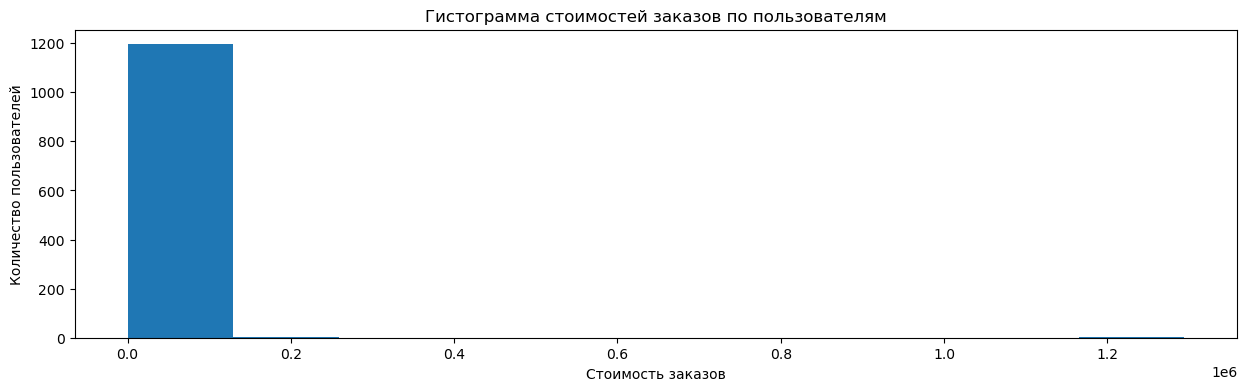

In [18]:
# Построим гистограмму распределения выручекс заказов по пользователям методом hist()
plt.figure(figsize=(15, 4))
plt.hist(orders['revenue'])
plt.title("Гистограмма стоимостей заказов по пользователям")
plt.ylabel("Количество пользователей")
plt.xlabel("Стоимость заказов")
plt.show()

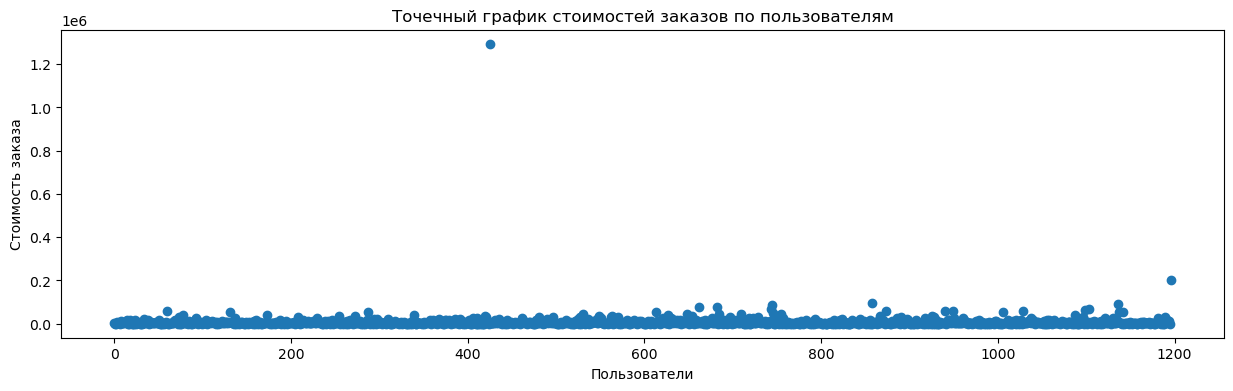

In [19]:
# Построим диаграмму методом scatter()
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 4))
plt.scatter(x_values, orders['revenue'])
plt.title("Точечный график стоимостей заказов по пользователям")
plt.ylabel("Стоимость заказа")
plt.xlabel("Пользователи")
plt.show()

**Вывод:**

Один из заказов - почти 1.3 млн.!    
В основном, стоимость заказа не превышает 20 000, даже несколько ниже этой цифры.

##### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [20]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:**
Определяем границу по величине 99% перцентиля (58233)

##### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Уровень статистической значимости: **0.05**

**Сформулируем гипотезы:**
- Нулевая: различий в среднем количестве заказов между группами нет;
- Альтернативная: различия в среднем между группами есть.

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [22]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

0.01679
0.138


**Вывод:** 
    
P-value = 0.01679 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем в пользу альтернативной гипотезы - среднее число заказов на пользователя между группами различается.

Количество заказов на пользователя в группе Б на 13,8% превышает аналогичный показатель группы А.

##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

In [23]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


**Вывод:** 
    
P-value = 0.729 и значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
Различия в среднем чеке между группами составляют 25.9%

##### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

Ранее мы приняли за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58 233 рублей. 

In [24]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[1]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[1]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[1]]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape[0]) 

15


Всего 15 аномальных пользователей

In [25]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [26]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.014
0.153


**Вывод:** 
    
P-value = 0.014 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем в пользу альтернативной гипотезы - среднее число заказов на пользователя между группами различается.

Количество заказов на пользователя в группе Б на 15,3% превышает аналогичный показатель группы А.

##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

In [27]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
print(
    '{0:.3f}'.format(
        
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'].mean() /
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'].mean()-1
    )
)

0.851
0.006


**Вывод:**

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. По разнице средних чеков групп различий практически нет.

### Вывод.

1. В части приоритизации гипотез из списка, предоставленных отделом Маркетинга следует в первую очередь обратить внимание на гипотезы:
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

2. В части анализа А/В теста:

- Есть статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий. Конверсия группы В выше, чем в А, на 14-15%;
- cредний чек по группам одинаков;

3. Таким образом, **можно зафиксировать победу группы Б** - следовательно, необходимость в продолжении теста отсутствует.